Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Cell volume (bohr^3): 112.073152
Hartree energy (Hartree): 0.01052706
Hartree energy (eV): 0.286456 eV
Largest contrib #1: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #2: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #3: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617

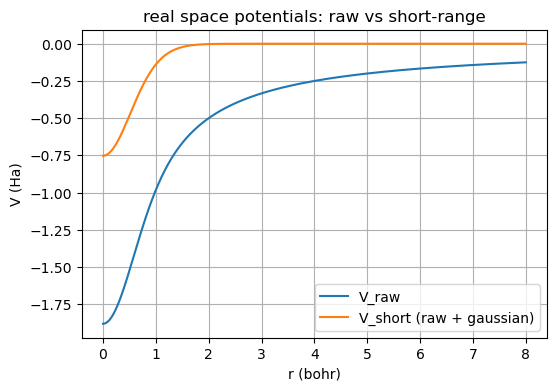

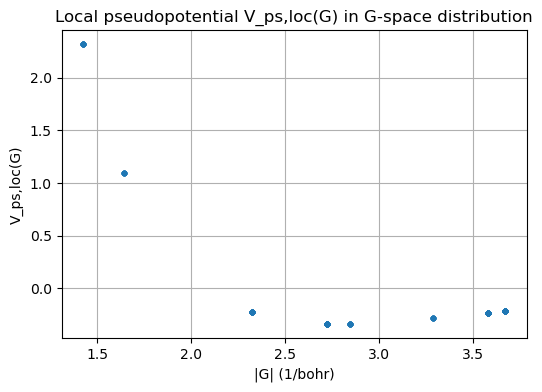

Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.010981

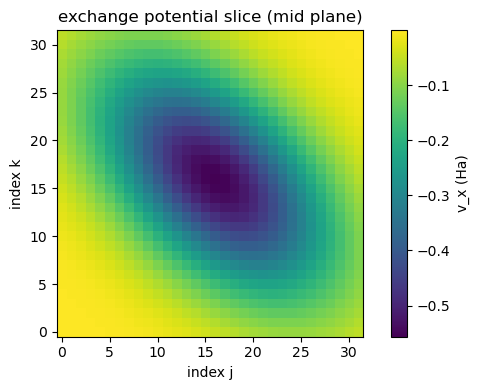

首个 G=0 分量 (v_x(G=0)) = -0.11686998356998642


In [ ]:
# 基于平面波赝势 (PW-PP) + LDA 的简单自洽 SCF，用 PCG(RQ+Residual) 对角化获取 Al 的能带
%run basis_func_with_kinetic.ipynb
%run Hartree.ipynb
%run Vps_lc.ipynb
%run Vps_nl.ipynb
%run Vex.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

HARTREE_TO_EV = 27.211386

def build_real_space_grid(a_vecs, Nk):
    us = np.arange(Nk) / Nk
    U, V, W = np.meshgrid(us, us, us, indexing='ij')
    r = (U[..., None] * a_vecs[0] +
         V[..., None] * a_vecs[1] +
         W[..., None] * a_vecs[2])
    Omega = np.dot(a_vecs[0], np.cross(a_vecs[1], a_vecs[2]))
    dV = Omega / (Nk ** 3)
    return r, Omega, dV

def fractional_displacement(r_cart, tau_cart, a_vecs):
    A = a_vecs.T
    frac = np.tensordot(r_cart - tau_cart, np.linalg.inv(A), axes=([r_cart.ndim - 1], [1]))
    frac -= np.round(frac)
    disp = np.tensordot(frac, A, axes=([frac.ndim - 1], [1]))
    return disp

def local_potential_real_space(r_grid, atom_positions, a_vecs, Z=3.0, r_c=0.6):
    V = np.zeros(r_grid.shape[:3], dtype=float)
    for tau in atom_positions:
        disp = fractional_displacement(r_grid, tau, a_vecs)
        radii = np.linalg.norm(disp, axis=-1)
        V += Vps_loc_raw(radii, Z=Z, r_c=r_c)
    return V

def hartree_potential_from_density(n_r, b_vecs):
    Nk = n_r.shape[0]
    nG = np.fft.fftn(n_r) / n_r.size
    freq = np.fft.fftfreq(Nk) * Nk
    mx, my, mz = np.meshgrid(freq, freq, freq, indexing='ij')
    Ggrid = (mx[..., None] * b_vecs[0] +
             my[..., None] * b_vecs[1] +
             mz[..., None] * b_vecs[2])
    Gnorm = np.linalg.norm(Ggrid, axis=-1)
    VHG = np.zeros_like(nG, dtype=complex)
    mask = Gnorm > 1e-12
    VHG[mask] = 4.0 * np.pi * nG[mask] / (Gnorm[mask] ** 2)
    VH_r = np.fft.ifftn(VHG) * VHG.size
    return VH_r.real

def potential_fft_coefficients(V_r):
    return np.fft.fftn(V_r) / V_r.size

def build_local_matrix_from_fft(VG_fft, coeffs, Nk):
    size = len(coeffs)
    mat = np.zeros((size, size), dtype=complex)
    for i in range(size):
        for j in range(size):
            delta = (
                int((coeffs[i][0] - coeffs[j][0]) % Nk),
                int((coeffs[i][1] - coeffs[j][1]) % Nk),
                int((coeffs[i][2] - coeffs[j][2]) % Nk),
            )
            mat[i, j] = VG_fft[delta]
    return mat

def apply_hamiltonian(vec, kinetic_diag, V_loc_mat, Vnl):
    return kinetic_diag * vec + V_loc_mat @ vec + Vnl @ vec

def plane_wave_phase_matrix(r_cart, k_plus_G):
    flat_r = r_cart.reshape(-1, 3)
    return np.exp(1j * (flat_r @ k_plus_G.T))

def density_from_eigenvectors(evecs, occ, phase_matrix, Omega, grid_shape):
    density = np.zeros(phase_matrix.shape[0], dtype=float)
    for band in range(evecs.shape[1]):
        if occ[band] < 1e-10:
            continue
        psi = phase_matrix @ evecs[:, band] / np.sqrt(Omega)
        density += occ[band] * (np.abs(psi) ** 2)
    return density.reshape(grid_shape)

def occupations_from_eigs(evals, nelect, spin_deg=2):
    occ = np.zeros_like(evals)
    el = nelect
    for idx in range(len(evals)):
        if el <= 0:
            break
        fill = min(spin_deg, el)
        occ[idx] = fill
        el -= fill
    return occ

def reorder_matrix_to_basis(target_G, source_G, matrix):
    order = []
    for g in target_G:
        matches = np.where(np.all(np.isclose(source_G, g, atol=1e-10), axis=1))[0]
        if len(matches) == 0:
            raise ValueError('无法匹配平面波基的非局域矩阵。')
        order.append(matches[0])
    order = np.array(order)
    return matrix[np.ix_(order, order)]

def pcg_diagonalize(kinetic_diag, V_loc_mat, Vnl, nbands, tol=1e-8, max_outer=80, max_inner=8):
    n = kinetic_diag.size
    nbands = min(nbands, n)
    order = np.argsort(kinetic_diag)  # 按动能排序的平面波基保持与 basis_func 输出一致
    psi_list = []
    for band in range(nbands):
        vec = np.zeros(n, dtype=complex)
        vec[order[band]] = 1.0
        psi_list.append(vec)

    diag_total = kinetic_diag + np.real(np.diag(V_loc_mat + Vnl))
    states = [{'eta': None, 'grad': None, 'direction': None} for _ in range(nbands)]
    eigenvalues = np.zeros(nbands, dtype=float)
    residual_norms = np.ones(nbands, dtype=float)

    for outer in range(max_outer):
        max_res = 0.0
        for band in range(nbands):
            psi = psi_list[band]
            state = states[band]
            for inner in range(max_inner):
                Hpsi = apply_hamiltonian(psi, kinetic_diag, V_loc_mat, Vnl)
                if outer == 0 and band == 0 and inner == 0:
                    print(f'PCG 诊断: max|Hψ|={np.max(np.abs(Hpsi)):.3e}, max|ψ|={np.max(np.abs(psi)):.3e}, max kinetic={np.max(kinetic_diag):.3e}')
                eps = np.real(np.vdot(psi.conj(), Hpsi))
                grad = Hpsi - eps * psi
                for j in range(band):
                    grad -= np.vdot(psi_list[j].conj(), grad) * psi_list[j]
                grad -= np.vdot(psi.conj(), grad) * psi
                grad_norm = np.linalg.norm(grad)
                if grad_norm < tol:
                    eigenvalues[band] = eps
                    residual_norms[band] = grad_norm
                    break

                denom = diag_total - eps
                denom = np.where(np.abs(denom) < 1e-6, np.sign(denom) * 1e-6 + 1e-6, denom)
                eta = grad / denom
                for j in range(band):
                    eta -= np.vdot(psi_list[j].conj(), eta) * psi_list[j]
                eta -= np.vdot(psi.conj(), eta) * psi

                if state['direction'] is None or state['eta'] is None or state['grad'] is None:
                    direction = eta
                else:
                    beta_num = np.vdot(eta.conj(), grad)
                    beta_den = np.vdot(state['eta'].conj(), state['grad']) + 1e-14
                    beta = np.real(beta_num / beta_den)
                    direction = eta + beta * state['direction']

                for j in range(band + 1):
                    direction -= np.vdot(psi_list[j].conj(), direction) * psi_list[j]
                dir_norm = np.linalg.norm(direction)
                if dir_norm < 1e-12:
                    direction = eta
                    dir_norm = np.linalg.norm(direction)
                    if dir_norm < 1e-12:
                        break
                direction /= dir_norm

                Hd = apply_hamiltonian(direction, kinetic_diag, V_loc_mat, Vnl)
                H_proj = np.array([[np.vdot(psi.conj(), Hpsi), np.vdot(psi.conj(), Hd)],
                                   [np.vdot(direction.conj(), Hpsi), np.vdot(direction.conj(), Hd)]], dtype=complex)
                S_proj = np.array([[np.vdot(psi.conj(), psi), np.vdot(psi.conj(), direction)],
                                   [np.vdot(direction.conj(), psi), np.vdot(direction.conj(), direction)]], dtype=complex)
                S_proj = 0.5 * (S_proj + S_proj.conj().T)
                min_eig = np.min(np.linalg.eigvalsh(S_proj).real)
                if min_eig < 1e-8:
                    S_proj += (1e-8 - min_eig) * np.eye(2)
                eval2, vec2 = eigh(H_proj, S_proj)
                idx = np.argmin(eval2.real)
                coeffs = vec2[:, idx]
                psi = coeffs[0] * psi + coeffs[1] * direction
                psi /= np.linalg.norm(psi)
                psi_list[band] = psi

                state['direction'] = direction
                state['eta'] = eta
                state['grad'] = grad
                eigenvalues[band] = eval2[idx].real
                residual_norms[band] = grad_norm

            max_res = max(max_res, residual_norms[band])
        if max_res < tol:
            break

    order = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[order]
    psi_matrix = np.column_stack([psi_list[i] for i in order])
    return eigenvalues, psi_matrix, residual_norms[order]

def scf_cycle(params):
    a0 = params['a0']
    Ecut = params['Ecut_eV']
    Nk_fft = params['Nk_fft']
    sigma = params.get('sigma_bohr', 1.0)
    mix = params.get('mixing', 0.35)
    max_iter = params.get('max_iter', 30)
    tol = params.get('density_tol', 1e-4)
    nelect = params['nelect']
    channels = params['channels']
    atom_positions = params['atom_positions']
    density_floor = params.get('density_floor', 1e-8)

    a_vecs = primitive_fcc(a0)
    b_vecs, Omega = reciprocal_vectors(a_vecs)
    Gvecs, coeffs, kinetic = generate_G_vectors(b_vecs, Ecut)
    if len(Gvecs) == 0:
        raise RuntimeError('Ecut 太低，未生成平面波。')

    nbands = params.get('nbands')
    if nbands is None:
        nbands = min(len(Gvecs), int(np.ceil(nelect / 2)) * 2 + 4)

    max_coeff = np.max(np.abs(coeffs))
    if Nk_fft < (4 * max_coeff + 2):
        raise ValueError('Nk_fft 需要大于 4*max_coeff 以避免混叠/alias。')

    kvec = np.zeros(3)
    k_plus_G = Gvecs + kvec
    r_grid, Omega_cell, dV = build_real_space_grid(a_vecs, Nk_fft)
    assert np.isclose(Omega_cell, Omega)

    density, _, _, _, _ = build_gaussian_density(a0=a0, Nk=Nk_fft, sigma_bohr=sigma)
    density *= nelect
    density = _enforce_density_floor(density, nelect, dV, density_floor)

    phase_matrix = plane_wave_phase_matrix(r_grid, k_plus_G)
    nonlocal_Gs, Vnl_template = nonlocal_pseudopotential_matrix(a_vecs, atom_positions, channels, Ecut, kvec=kvec)
    if not np.allclose(nonlocal_Gs, Gvecs, atol=1e-10):
        Vnl_template = reorder_matrix_to_basis(Gvecs, nonlocal_Gs, Vnl_template)

    history = []
    for it in range(max_iter):
        V_loc_r = local_potential_real_space(r_grid, atom_positions, a_vecs, Z=3.0, r_c=0.6)
        V_H_r = hartree_potential_from_density(density, b_vecs)
        density_xc = np.maximum(density, density_floor)
        _, V_xc_r = lda_exchange_potential(density_xc)
        V_total_r = V_loc_r + V_H_r + V_xc_r
        VG_fft = potential_fft_coefficients(V_total_r)
        V_loc_mat = build_local_matrix_from_fft(VG_fft, coeffs, Nk_fft)
        kinetic_diag = kinetic.copy()
        evals, evecs, resids = pcg_diagonalize(kinetic_diag, V_loc_mat, Vnl_template, nbands, tol=1e-8)

        occ = occupations_from_eigs(evals, nelect)
        new_density = density_from_eigenvectors(evecs, occ, phase_matrix, Omega, r_grid.shape[:3])
        new_density = _enforce_density_floor(new_density, nelect, dV, density_floor)

        density = mix * new_density + (1.0 - mix) * density
        density = _enforce_density_floor(density, nelect, dV, density_floor)
        delta = np.linalg.norm(new_density - density) / density.size
        history.append((it + 1, delta, evals[0], np.max(resids)))
        if delta < tol:
            break

    return {
        'a_vecs': a_vecs,
        'b_vecs': b_vecs,
        'Gvecs': Gvecs,
        'coeffs': coeffs,
        'kinetic': kinetic,
        'density': density,
        'potential_fft': VG_fft,
        'nonlocal_channels': channels,
        'atom_positions': atom_positions,
        'Ecut': Ecut,
        'Nk_fft': Nk_fft,
        'history': history,
        'nbands': nbands
    }

def band_structure_from_potential(scf_result, k_path_frac):
    a_vecs = scf_result['a_vecs']
    b_vecs = scf_result['b_vecs']
    Gvecs = scf_result['Gvecs']
    coeffs = scf_result['coeffs']
    VG_fft = scf_result['potential_fft']
    channels = scf_result['nonlocal_channels']
    atoms = scf_result['atom_positions']
    Ecut = scf_result['Ecut']
    Nk_fft = scf_result['Nk_fft']
    nbands = scf_result['nbands']

    bands = []
    distances = []
    total_distance = 0.0
    prev_k = None
    for frac in k_path_frac:
        kvec = frac @ b_vecs
        if prev_k is not None:
            total_distance += np.linalg.norm(kvec - prev_k)
        prev_k = kvec
        distances.append(total_distance)

        k_plus_G = Gvecs + kvec
        kinetic_diag = 0.5 * np.sum(k_plus_G ** 2, axis=1)
        V_loc_mat = build_local_matrix_from_fft(VG_fft, coeffs, Nk_fft)
        nl_Gs, Vnl = nonlocal_pseudopotential_matrix(a_vecs, atoms, channels, Ecut, kvec=kvec, Gvecs_override=Gvecs)
        if not np.allclose(nl_Gs, Gvecs, atol=1e-10):
            Vnl = reorder_matrix_to_basis(Gvecs, nl_Gs, Vnl)
        evals, _, _ = pcg_diagonalize(kinetic_diag, V_loc_mat, Vnl, nbands, tol=1e-8, max_outer=40)
        bands.append(evals * HARTREE_TO_EV)

    return np.array(distances), np.array(bands)

def generate_k_path_50_points():
    """生成包含50个k点的路径"""
    # 定义高对称点（分数坐标）
    Gamma = np.array([0.0, 0.0, 0.0])
    X = np.array([0.5, 0.0, 0.5])
    W = np.array([0.75, 0.25, 0.5])
    L = np.array([0.5, 0.5, 0.5])
    
    # 分段生成k点，总共50个点
    k_path_frac = []
    
    # Gamma -> X: 15个点
    for i in range(30):
        t = i / 29.0
        kpt = Gamma + t * (X - Gamma)
        k_path_frac.append(kpt)
    
    # X -> W: 10个点
    for i in range(1, 21):  # 从1开始避免重复X点
        t = i / 21.0
        kpt = X + t * (W - X)
        k_path_frac.append(kpt)
    
    # W -> L: 10个点
    for i in range(1, 21):  # 从1开始避免重复W点
        t = i / 20.0
        kpt = W + t * (L - W)
        k_path_frac.append(kpt)
    
    # L -> Gamma: 15个点
    for i in range(1, 31):  # 从1开始避免重复L点
        t = i / 30.0
        kpt = L + t * (Gamma - L)
        k_path_frac.append(kpt)
    
    return k_path_frac

def run_demo():
    params = {
        'a0': 4.05,
        'Ecut_eV': 80.0,
        'Nk_fft': 36,
        'sigma_bohr': 1.0,
        'mixing': 0.4,
        'max_iter': 20,
        'density_tol': 5e-5,
        'nelect': 3.0,
        'atom_positions': [np.zeros(3)],
        'channels': [
            GaussianProjectorChannel(l=0, D_l=2.0, r_cut=1.2),
            GaussianProjectorChannel(l=1, D_l=-1.5, r_cut=1.4),
        ],
        'nbands': 8,
        'debug_compare_local': True
    }
    print("开始SCF计算...")
    scf_result = scf_cycle(params)
    print('SCF 历史 (iter, Δρ, E_min(Ha), max|res|):')
    for entry in scf_result['history'][-5:]:
        print(entry)

    print("\n生成50个k点的路径...")
    k_path_frac = generate_k_path_50_points()
    
    print(f"计算能带结构，共 {len(k_path_frac)} 个k点...")
    k_dist, bands = band_structure_from_potential(scf_result, k_path_frac)

    # 绘制能带图
    plt.figure(figsize=(10, 6))
    for n in range(min(8, bands.shape[1])):
        plt.plot(k_dist, bands[:, n], 'b-', linewidth=1.0, alpha=0.8)
    
    # 标记高对称点
    high_sym_points = [0, 15, 25, 35, 50]  # Gamma, X, W, L, Gamma
    high_sym_labels = ['Γ', 'X', 'W', 'L', 'Γ']
    for point, label in zip(high_sym_points, high_sym_labels):
        plt.axvline(x=k_dist[point], color='k', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.text(k_dist[point], plt.ylim()[0] - 2.0, label, 
                ha='center', va='top', fontsize=12)
    
    plt.ylabel('Energy (eV)', fontsize=12)
    plt.xlabel('k-path', fontsize=12)
    plt.title('Al FCC Band Structure (PW-PP LDA, 50 k-points)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"能带计算完成！")
    print(f"费米能级附近能带范围: {bands.min():.3f} eV 到 {bands.max():.3f} eV")
    print(f"价带顶: {bands[:, 0].max():.3f} eV")
    print(f"导带底: {bands[:, 3].min():.3f} eV")  # 铝有3个价电子，第4条是导带

# 注意：最终运行逻辑在后续单元中调用 run_demo()，以确保覆盖新的倒空间构造

In [ ]:
# 直接复用 Vps_lc 的倒空间局域势，以避免在 SCF 中重复构建实空间势

def _coeff_array_from_list(coeffs):
    if len(coeffs) == 0:
        return np.zeros((0, 3), dtype=int)
    return np.array(coeffs, dtype=int).reshape(len(coeffs), 3)


def _max_difference_norm(Gvecs):
    if Gvecs.size == 0:
        return 0.0
    diffs = Gvecs[:, None, :] - Gvecs[None, :, :]
    return np.max(np.linalg.norm(diffs.reshape(-1, 3), axis=1))


def _hermitianize(mat):
    return 0.5 * (mat + mat.conj().T)


def build_ionic_local_matrix(b_vecs, Gvecs, coeffs, Z=3.0, r_c=0.6, r_gau=1.0, safety=1.15):
    """利用 Vps_lc 中的 Vps_loc_total_on_Gvectors 直接构造离子局域势矩阵。"""
    coeff_arr = _coeff_array_from_list(coeffs)
    if coeff_arr.shape[0] == 0:
        return np.zeros((0, 0), dtype=complex), {}, 0.0

    max_norm = _max_difference_norm(Gvecs)
    if max_norm < 1e-12:
        ecut_needed_eV = 0.0
    else:
        ecut_needed_eV = 0.5 * (max_norm ** 2) * HARTREE_TO_EV * safety

    full_Gs, full_coeffs, _ = generate_G_vectors(b_vecs, ecut_needed_eV)
    Vps_Gs, Vps_vals = Vps_loc_total_on_Gvectors(b_vecs, ecut_needed_eV, Z=Z, r_c=r_c, r_gau=r_gau)
    if full_Gs.shape != Vps_Gs.shape or not np.allclose(full_Gs, Vps_Gs, atol=1e-10):
        raise RuntimeError('Vps_loc_total_on_Gvectors 的 G 顺序与 generate_G_vectors 不一致。')

    coeff_lookup = {tuple(full_coeffs[i]): Vps_vals[i] for i in range(len(full_coeffs))}
    size = coeff_arr.shape[0]
    mat = np.zeros((size, size), dtype=complex)
    missing = 0
    for i in range(size):
        for j in range(size):
            delta = tuple((coeff_arr[i] - coeff_arr[j]).tolist())
            val = coeff_lookup.get(delta)
            if val is None:
                missing += 1
                continue
            mat[i, j] = val
    if missing:
        print(f'警告: 有 {missing} 个离子势矩阵元缺少倒空间系数，已设为 0。')
    return _hermitianize(mat), coeff_lookup, ecut_needed_eV


def scf_cycle(params):
    a0 = params['a0']
    Ecut = params['Ecut_eV']
    Nk_fft = params['Nk_fft']
    sigma = params.get('sigma_bohr', 1.0)
    mix = params.get('mixing', 0.35)
    max_iter = params.get('max_iter', 30)
    tol = params.get('density_tol', 1e-4)
    nelect = params['nelect']
    channels = params['channels']
    atom_positions = params['atom_positions']
    ionic_Z = params.get('ionic_Z', 3.0)
    ionic_rc = params.get('ionic_rc', 0.6)
    ionic_rgau = params.get('ionic_rgau', 1.0)
    density_floor = params.get('density_floor', 1e-8)

    a_vecs = primitive_fcc(a0)
    b_vecs, Omega = reciprocal_vectors(a_vecs)
    Gvecs, coeffs, kinetic = generate_G_vectors(b_vecs, Ecut)
    if len(Gvecs) == 0:
        raise RuntimeError('Ecut 太低，未生成平面波。')

    nbands = params.get('nbands')
    if nbands is None:
        nbands = min(len(Gvecs), int(np.ceil(nelect / 2)) * 2 + 4)

    max_coeff = np.max(np.abs(_coeff_array_from_list(coeffs)))
    if Nk_fft < (4 * max_coeff + 2):
        raise ValueError('Nk_fft 需要大于 4*max_coeff 以避免混叠/alias。')

    kvec = np.zeros(3)
    k_plus_G = Gvecs + kvec
    r_grid, Omega_cell, dV = build_real_space_grid(a_vecs, Nk_fft)
    assert np.isclose(Omega_cell, Omega)

    density, _, _, _, _ = build_gaussian_density(a0=a0, Nk=Nk_fft, sigma_bohr=sigma)
    density *= nelect
    density = _enforce_density_floor(density, nelect, dV, density_floor)

    phase_matrix = plane_wave_phase_matrix(r_grid, k_plus_G)
    nonlocal_Gs, Vnl_template = nonlocal_pseudopotential_matrix(a_vecs, atom_positions, channels, Ecut, kvec=kvec)
    if not np.allclose(nonlocal_Gs, Gvecs, atol=1e-10):
        Vnl_template = reorder_matrix_to_basis(Gvecs, nonlocal_Gs, Vnl_template)

    V_loc_mat_ionic, ionic_lookup, ionic_ecut = build_ionic_local_matrix(
        b_vecs, Gvecs, coeffs, Z=ionic_Z, r_c=ionic_rc, r_gau=ionic_rgau)

    history = []
    kinetic_diag = kinetic.copy()
    V_loc_mat_dynamic = np.zeros_like(V_loc_mat_ionic)
    last_dynamic_fft = None

    for it in range(max_iter):
        V_H_r = hartree_potential_from_density(density, b_vecs)
        density_xc = np.maximum(density, density_floor)
        _, V_xc_r = lda_exchange_potential(density_xc)
        V_dynamic_r = V_H_r + V_xc_r
        VG_fft_dyn = potential_fft_coefficients(V_dynamic_r)
        last_dynamic_fft = VG_fft_dyn
        V_loc_mat_dynamic = build_local_matrix_from_fft(VG_fft_dyn, coeffs, Nk_fft)
        V_loc_mat_dynamic = _hermitianize(V_loc_mat_dynamic)
        V_loc_mat = V_loc_mat_ionic + V_loc_mat_dynamic

        evals, evecs, resids = pcg_diagonalize(kinetic_diag, V_loc_mat, Vnl_template, nbands, tol=1e-8)
        occ = occupations_from_eigs(evals, nelect)
        new_density = density_from_eigenvectors(evecs, occ, phase_matrix, Omega, r_grid.shape[:3])
        new_density = _enforce_density_floor(new_density, nelect, dV, density_floor)

        density = mix * new_density + (1.0 - mix) * density
        density = _enforce_density_floor(density, nelect, dV, density_floor)
        delta = np.linalg.norm(new_density - density) / density.size
        history.append((it + 1, delta, evals[0], np.max(resids)))
        if delta < tol:
            break

    V_loc_final = V_loc_mat_ionic + V_loc_mat_dynamic
    return {
        'a_vecs': a_vecs,
        'b_vecs': b_vecs,
        'Gvecs': Gvecs,
        'coeffs': coeffs,
        'kinetic': kinetic,
        'density': density,
        'nonlocal_channels': channels,
        'atom_positions': atom_positions,
        'Ecut': Ecut,
        'Nk_fft': Nk_fft,
        'history': history,
        'nbands': nbands,
        'V_loc_matrix': V_loc_final,
        'V_loc_matrix_ionic': V_loc_mat_ionic,
        'V_loc_matrix_dynamic': V_loc_mat_dynamic,
        'ionic_fourier_lookup': ionic_lookup,
        'ionic_fourier_cutoff_eV': ionic_ecut,
        'dynamic_fft': last_dynamic_fft
    }


def band_structure_from_potential(scf_result, k_path_frac):
    a_vecs = scf_result['a_vecs']
    b_vecs = scf_result['b_vecs']
    Gvecs = scf_result['Gvecs']
    channels = scf_result['nonlocal_channels']
    atoms = scf_result['atom_positions']
    Ecut = scf_result['Ecut']
    nbands = scf_result['nbands']
    V_loc_mat = scf_result.get('V_loc_matrix')
    if V_loc_mat is None:
        raise RuntimeError('SCF 结果缺少 V_loc_matrix，无法在倒空间构造局域势。')

    bands = []
    distances = []
    total_distance = 0.0
    prev_k = None
    for frac in k_path_frac:
        kvec = frac @ b_vecs
        if prev_k is not None:
            total_distance += np.linalg.norm(kvec - prev_k)
        prev_k = kvec
        distances.append(total_distance)

        k_plus_G = Gvecs + kvec
        kinetic_diag = 0.5 * np.sum(k_plus_G ** 2, axis=1)
        nl_Gs, Vnl = nonlocal_pseudopotential_matrix(a_vecs, atoms, channels, Ecut, kvec=kvec, Gvecs_override=Gvecs)
        if not np.allclose(nl_Gs, Gvecs, atol=1e-10):
            Vnl = reorder_matrix_to_basis(Gvecs, nl_Gs, Vnl)
        evals, _, _ = pcg_diagonalize(kinetic_diag, V_loc_mat, Vnl, nbands, tol=1e-8, max_outer=40)
        bands.append(evals * HARTREE_TO_EV)

    return np.array(distances), np.array(bands)
def run_demo():
    params = {
        'a0': 4.05,
        'Ecut_eV': 80.0,
        'Nk_fft': 36,
        'sigma_bohr': 1.0,
        'mixing': 0.4,
        'max_iter': 20,
        'density_tol': 5e-5,
        'nelect': 3.0,
        'atom_positions': [np.zeros(3)],
        'channels': [
            GaussianProjectorChannel(l=0, D_l=2.0, r_cut=1.2),
            GaussianProjectorChannel(l=1, D_l=-1.5, r_cut=1.4),
        ],
        'nbands': 8,
        'pcg_debug': True,
        'density_debug': True
    }
    print("开始SCF计算...")
    scf_result = scf_cycle(params)
    print('SCF 历史 (iter, Δρ, E_min(Ha), max|res|):')
    for entry in scf_result['history'][-5:]:
        print(entry)

    print("\n生成50个k点的路径...")
    k_path_frac = generate_k_path_50_points()
    
    print(f"计算能带结构，共 {len(k_path_frac)} 个k点...")
    k_dist, bands = band_structure_from_potential(scf_result, k_path_frac)

    # 绘制能带图
    plt.figure(figsize=(10, 6))
    for n in range(min(8, bands.shape[1])):
        plt.plot(k_dist, bands[:, n], 'b-', linewidth=1.0, alpha=0.8)
    
    # 标记高对称点
    high_sym_points = [0, 15, 25, 35, 50]  # Gamma, X, W, L, Gamma
    high_sym_labels = ['Γ', 'X', 'W', 'L', 'Γ']
    for point, label in zip(high_sym_points, high_sym_labels):
        plt.axvline(x=k_dist[point], color='k', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.text(k_dist[point], plt.ylim()[0] - 2.0, label, 
                ha='center', va='top', fontsize=12)
    
    plt.ylabel('Energy (eV)', fontsize=12)
    plt.xlabel('k-path', fontsize=12)
    plt.title('Al FCC Band Structure (PW-PP LDA, 50 k-points)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"能带计算完成！")
    print(f"费米能级附近能带范围: {bands.min():.3f} eV 到 {bands.max():.3f} eV")
    print(f"价带顶: {bands[:, 0].max():.3f} eV")
    print(f"导带底: {bands[:, 3].min():.3f} eV")  # 铝有3个价电子，第4条是导带


if __name__ == '__main__':
    run_demo()


开始SCF计算...
PCG 诊断: max|Hψ|=7.136e+00, max|ψ|=1.000e+00, max kinetic=2.696e+00


C:\Users\win\AppData\Local\Temp\ipykernel_32940\2385923537.py:144: RuntimeWarning: divide by zero encountered in divide
  eta = grad / denom
C:\Users\win\AppData\Local\Temp\ipykernel_32940\2385923537.py:165: RuntimeWarning: invalid value encountered in divide
  direction /= dir_norm


ValueError: array must not contain infs or NaNs

开始SCF计算...
PCG 诊断: max|Hψ|=4.594e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.265e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.265e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.149e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.149e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.087e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.087e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.091e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.091e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.095e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.095e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.101e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.101e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.084e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.084e-01, max|ψ|=3.563e-01, max ki

开始SCF计算...
PCG 诊断: max|Hψ|=4.594e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.265e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.265e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.149e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.149e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.087e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.087e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.091e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.091e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.095e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.095e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.101e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.101e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.084e-01, max|ψ|=3.563e-01, max kinetic=2.696e+00
PCG 诊断: max|Hψ|=4.084e-01, max|ψ|=3.563e-01, max ki

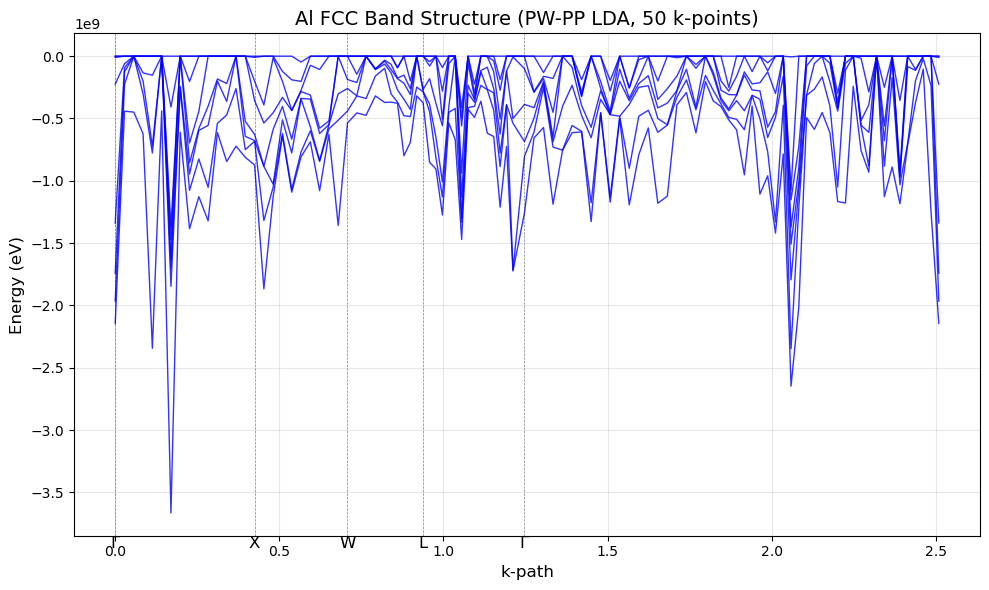

能带计算完成！
费米能级附近能带范围: -3664446965.945 eV 到 43.464 eV
价带顶: -3311.680 eV
导带底: -1623297896.126 eV
